# Colour - Checker Detection - Examples: Inference

This notebook showcases machine learning inference retated colour checker detection examples.

The inference is performed by [Ultralytics YOLOv8](https://github.com/ultralytics/ultralytics)

The model is published on [HuggingFace](<https://huggingface.co/colour-science/colour-checker-detection-models), it was trained on a purposely constructed [dataset](https://huggingface.co/datasets/colour-science/colour-checker-detection-dataset).

<div class="alert alert-warning">
The model has only been trained on <em>ColorChecker Classic 24</em> images and will not work with <em>ColorChecker Nano</em> or <em>ColorChecker SG</em> images.
</div>

<div class="alert alert-danger">
Inference is performed by a script licensed under the terms of the <em>GNU Affero General Public License v3.0</em> as it uses the <em>Ultralytics YOLOv8</em> API which is incompatible with the <em>BSD-3-Clause</em>.
</div>

<div class="alert alert-danger">
This notebook also uses the <em>Ultralytics YOLOv8</em> API directly at the end for demonstration purposes and is thus also licensed under the terms of the <em>GNU Affero General Public License v3.0</em>.
</div>

<div class="alert alert-info">
The original *.CR2 files were processed with <em>dcraw</em> as follows: <code>dcraw -T -g 2.4 12.92 *.CR2</code> and then resized and converted to *.png with <em>Image Magick</em> as follows: <code>mogrify -resize 50% -format png *.tiff</code>.
</div>

In [1]:
import glob
import os

import colour
import numpy as np
from colour.hints import Any, ArrayLike

from colour_checker_detection import (
    ROOT_RESOURCES_EXAMPLES,
    detect_colour_checkers_inference,
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC    *
*   v.1944 64 bit (AMD64)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.7                                                        *
*       colour-checker-detection : v0.2.1-50-gf0990c3                         *
*                                                                             *
*   Runtime :                                                                 *
*       matplotlib : 3.10.8                                                   *
*       numpy : 2.2.6                                                         *
*       scipy : 1.16.3                  

## Images

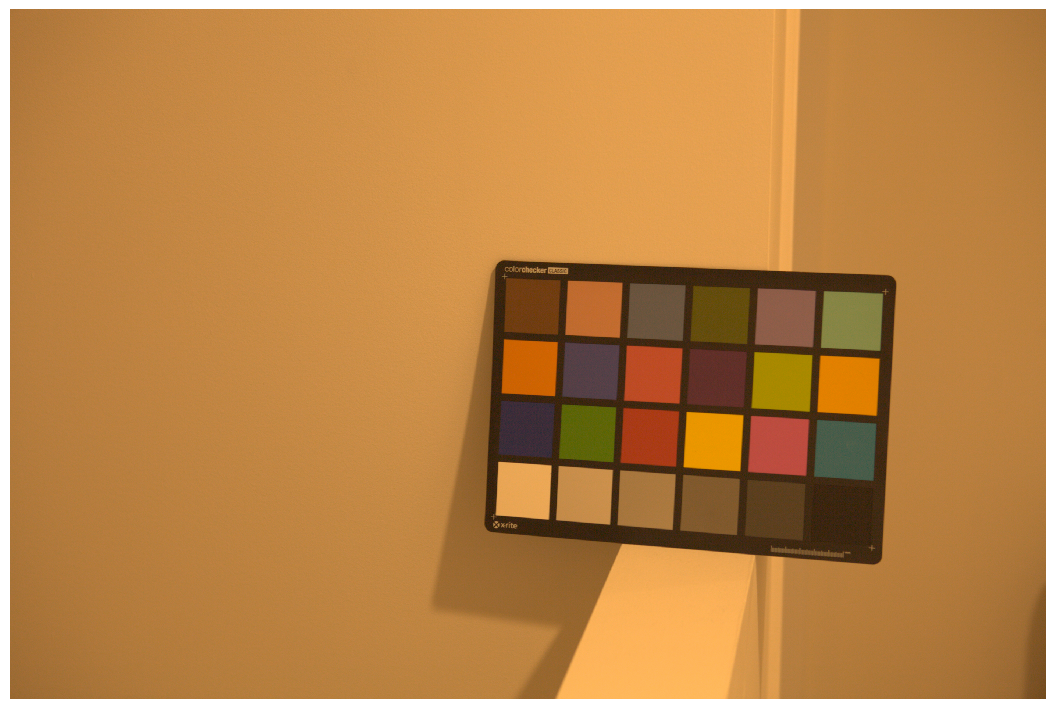

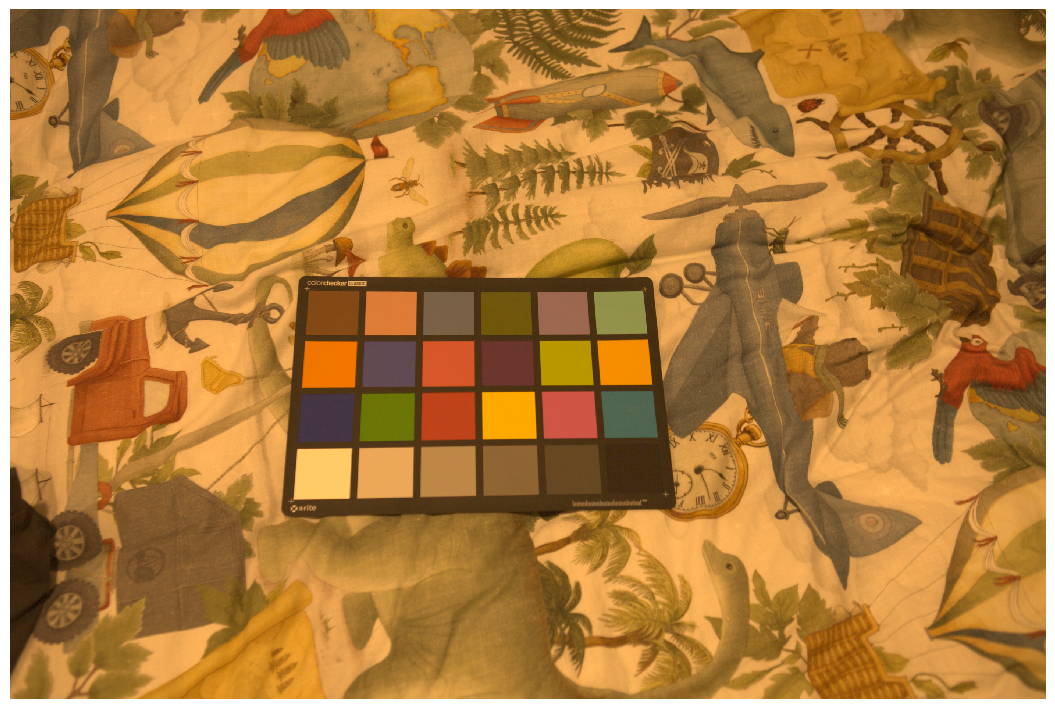

In [2]:
COLOUR_CHECKER_IMAGE_PATHS = glob.glob(
    os.path.join(ROOT_RESOURCES_EXAMPLES, "detection", "*25*.png")
)

COLOUR_CHECKER_IMAGES = [
    colour.cctf_decoding(colour.io.read_image(path))
    for path in COLOUR_CHECKER_IMAGE_PATHS
]

for image in COLOUR_CHECKER_IMAGES:
    colour.plotting.plot_image(colour.cctf_encoding(image))

## Detection

In [3]:
SWATCHES = []
for image in COLOUR_CHECKER_IMAGES:
    SWATCHES.extend(detect_colour_checkers_inference(image, show=True))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Victor\\AppData\\Local\\Temp\\tmp_430w_b8\\output-results.npz'

## Colour Fitting

In [ ]:
D65 = colour.CCS_ILLUMINANTS["CIE 1931 2 Degree Standard Observer"]["D65"]
REFERENCE_COLOUR_CHECKER = colour.CCS_COLOURCHECKERS[
    "ColorChecker24 - After November 2014"
]

colour_checker_rows = REFERENCE_COLOUR_CHECKER.rows
colour_checker_columns = REFERENCE_COLOUR_CHECKER.columns

# NOTE: The reference swatches values as produced by the "colour.XYZ_to_RGB"
# definition are linear by default.
# See https://github.com/colour-science/colour-checker-detection/discussions/59
# for more information.
REFERENCE_SWATCHES = colour.XYZ_to_RGB(
    colour.xyY_to_XYZ(list(REFERENCE_COLOUR_CHECKER.data.values())),
    "sRGB",
    REFERENCE_COLOUR_CHECKER.illuminant,
)

for i, swatches in enumerate(SWATCHES):
    swatches_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(swatches, "sRGB", D65))

    colour_checker = colour.characterisation.ColourChecker(
        os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i]),
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_xyY, strict=False)),
        D65,
        colour_checker_rows,
        colour_checker_columns,
    )

    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker]
    )

    swatches_f = colour.colour_correction(swatches, swatches, REFERENCE_SWATCHES)
    swatches_f_xyY = colour.XYZ_to_xyY(colour.RGB_to_XYZ(swatches_f, "sRGB", D65))
    colour_checker = colour.characterisation.ColourChecker(
        f"{os.path.basename(COLOUR_CHECKER_IMAGE_PATHS[i])} - CC",
        dict(zip(REFERENCE_COLOUR_CHECKER.data.keys(), swatches_f_xyY, strict=False)),
        D65,
        colour_checker_rows,
        colour_checker_columns,
    )

    colour.plotting.plot_multi_colour_checkers(
        [REFERENCE_COLOUR_CHECKER, colour_checker]
    )

    colour.plotting.plot_image(
        colour.cctf_encoding(
            colour.colour_correction(
                COLOUR_CHECKER_IMAGES[i], swatches, REFERENCE_SWATCHES
            )
        )
    )

## Additional Data Plotting

In [ ]:
for image in COLOUR_CHECKER_IMAGES:
    for _colour_checker_data in detect_colour_checkers_inference(image, show=True):
        ...

# Failures

The current inference process is prone to fail if the image is not that of a *ColorChecker Classic 24*, especially with the *ColorChecker Passport*:

<div class="alert alert-info">
The image path can also be passed directly to the detection definition and that it is possible to control the image decoding directly.
</div>

In [ ]:
COLOUR_CHECKER_IMAGE_PATH = next(
    iter(glob.glob(os.path.join(ROOT_RESOURCES_EXAMPLES, "detection", "*197*.png")))
)

for _colour_checker_data in detect_colour_checkers_inference(
    COLOUR_CHECKER_IMAGE_PATH, apply_cctf_decoding=True, show=True
):
    ...

In this specific case, it is possible to transform the image post-detection and horizontally compress it to have better swatch masks placement:

In [ ]:
for _colour_checker_data in detect_colour_checkers_inference(
    COLOUR_CHECKER_IMAGE_PATH,
    apply_cctf_decoding=True,
    inferred_confidence=0.875,
    transform={"scale": (1.15, 1)},
    show=True,
):
    ...

# Faster Inference with Custom Inferencer

In [ ]:
import time

from ultralytics import YOLO


def inferencer_agpl(image: ArrayLike, **kwargs: Any) -> None:  # noqa: D103
    model = YOLO(
        os.path.join(
            os.path.expanduser("~"),
            ".colour-science",
            "colour-checker-detection",
            "colour-checker-detection-l-seg.pt",
        ),
    )
    data = []

    # NOTE: YOLOv8 expects "BGR" arrays.
    if isinstance(image, np.ndarray):
        image = image[..., ::-1]

    image = colour.io.convert_bit_depth(image, np.uint8.__name__)

    # `device=0` for CUDA GPU
    for result in model(image):
        if result.boxes is None:
            continue

        if result.masks is None:
            continue

        data_boxes = result.boxes.data
        data_masks = result.masks.data

        for i in range(data_boxes.shape[0]):
            data.append(
                (
                    data_boxes[i, 4].cpu().numpy(),
                    data_boxes[i, 5].cpu().numpy(),
                    data_masks[i].data.cpu().numpy(),
                )
            )

    return data


print("Default Inferencer (Script via Sub-Process)")
for image in COLOUR_CHECKER_IMAGES:
    start = time.perf_counter()
    for _colour_checker_data in detect_colour_checkers_inference(image):
        ...

    print(f"Total Inference Time: {time.perf_counter() - start:.3f} seconds")

print("\n")

print("Custom Inferencer")
for image in COLOUR_CHECKER_IMAGES:
    start = time.perf_counter()
    for _colour_checker_data in detect_colour_checkers_inference(
        image, inferencer=inferencer_agpl
    ):
        ...

    print(f"Total Inference Time: {time.perf_counter() - start:.3f} seconds")